In [1]:
import os

corpus_base_dir = os.path.join('..', '..', '..', 'corpora', 'wired_it_20190821')

vocab_size = 10000
max_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
num_epochs = 30

training_dir = os.path.join(corpus_base_dir, 'training')
test_dir = os.path.join(corpus_base_dir, 'test')
classes = ['attualit_','attualit__ambiente','attualit__media','attualit__politica','attualit__tech','economia_business','economia_finanza','economia_lavoro','economia_startup','gadget_accessori','gadget_audio_e_tv','gadget_computer','gadget_elettrodomestici','gadget_foto_e_video','gadget_motori','gadget_outdoor','gadget_videogiochi','internet_regole','internet_social_network','internet_tlc','internet_web','lifestyle_design','lifestyle_food','lifestyle_mobilit_','lifestyle_salute','lifestyle_viaggi','lol','mobile_app','mobile_smartphone','mobile_tablet','play_cinema','play_cultura','play_fumetti','play_libri','play_musica','play_tv','scienza','scienza_biotech','scienza_ecologia','scienza_lab','scienza_medicina','scienza_spazio']

def read_file_to_text(file_path):
  with open(file_path, 'r', encoding="utf8") as file:
    return file.read().replace('\n', ' ')
def list_text_files(folder):
  return [os.path.join(folder, file_name) for file_name in os.listdir(folder) if file_name.endswith('.txt')]
flatten = lambda l: [item for sublist in l for item in sublist]

load_class_text_pairs = lambda folder: map(lambda classLabel: map(lambda file_name: (classLabel, read_file_to_text(file_name)), list_text_files(os.path.join(folder, classLabel))) , classes)

training_classes, training_texts = zip(*flatten(list(load_class_text_pairs(training_dir))))

test_classes, test_texts = zip(*flatten(list(load_class_text_pairs(test_dir))))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tensorflow as tf
import numpy as np

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_texts)
training_sequences = tokenizer.texts_to_sequences(training_texts)
training_padded = pad_sequences(training_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)


In [2]:
classes_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
classes_tokenizer.fit_on_texts(classes)

training_classes_seq = np.array(classes_tokenizer.texts_to_sequences(training_classes))
test_classes_seq = np.array(classes_tokenizer.texts_to_sequences(test_classes))

training_classes_encoded = [class_encoded[0] for class_encoded in training_classes_seq]
classes_word_index = classes_tokenizer.word_index
print(classes_word_index)
classes_by_index = dict([(index, key) for (key, index) in classes_word_index.items()])

{'attualit_': 1, 'attualit__ambiente': 2, 'attualit__media': 3, 'attualit__politica': 4, 'attualit__tech': 5, 'economia_business': 6, 'economia_finanza': 7, 'economia_lavoro': 8, 'economia_startup': 9, 'gadget_accessori': 10, 'gadget_audio_e_tv': 11, 'gadget_computer': 12, 'gadget_elettrodomestici': 13, 'gadget_foto_e_video': 14, 'gadget_motori': 15, 'gadget_outdoor': 16, 'gadget_videogiochi': 17, 'internet_regole': 18, 'internet_social_network': 19, 'internet_tlc': 20, 'internet_web': 21, 'lifestyle_design': 22, 'lifestyle_food': 23, 'lifestyle_mobilit_': 24, 'lifestyle_salute': 25, 'lifestyle_viaggi': 26, 'lol': 27, 'mobile_app': 28, 'mobile_smartphone': 29, 'mobile_tablet': 30, 'play_cinema': 31, 'play_cultura': 32, 'play_fumetti': 33, 'play_libri': 34, 'play_musica': 35, 'play_tv': 36, 'scienza': 37, 'scienza_biotech': 38, 'scienza_ecologia': 39, 'scienza_lab': 40, 'scienza_medicina': 41, 'scienza_spazio': 42}


In [3]:
import talos as ta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
import keras
from keras.activations import relu, elu
from talos.utils import hidden_layers

Using TensorFlow backend.


In [4]:
p = {
    # Hidden Layers
    #'shapes': ['brick', 'funnel', 'triangle'],
    'shapes': ['brick'],
    'first_neuron': [64, 128, 256],
    'hidden_layers':[1, 2],
    'dropout': [0, 0.05, 0.1, 0.2],
    'activation':['relu', 'elu'],
    
    # CNN
    'cnn_feature_maps': [256],
    #'cnn_filter_sizes': [2, 3, 4, 5],
    
    # Other
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10],
    'embedding_dims': [150, 300, 450],
    'batch_sizes': [15, 30, 45, 60]
}

def nlp_model(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()
    
    # Embeddings
    model.add(keras.layers.Embedding(vocab_size, params['embedding_dims'], input_length=max_length))
    
    # CNNs
    model.add(Conv1D(params['cnn_feature_maps'], 3, activation=params['activation'])),
    model.add(MaxPooling1D(3)),
    model.add(Flatten()),
    
    # Hidden layers
    hidden_layers(model, params, 1)
    
    # Output
    model.add(keras.layers.Dense(len(classes) + 1, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    
    out = model.fit(x_train, y_train, validation_data=[x_val, y_val], epochs=params['epochs'], batch_size=params['batch_sizes'], verbose=0)

    return out, model

h = ta.Scan(training_padded, training_classes_seq, model=nlp_model, params=p, fraction_limit=0.1, experiment_name="1")


  0%|                                                                                                     | 0/115 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0824 01:15:48.186558 18576 deprecation_wrapper.py:119] From C:\tools\Anaconda3\envs\talos_063_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 01:15:48.204509 18576 deprecation_wrapper.py:119] From C:\tools\Anaconda3\envs\talos_063_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 01:15:48.206504 18576 deprecation_wrapper.py:119] From C:\tools\Anaconda3\envs\talos_063_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 01:15:48.234429 18576 deprecation_wrapper.py:119] From C:\tools\Anaconda3\

In [5]:
h.data

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_sizes,cnn_feature_maps,dropout,embedding_dims,epochs,first_neuron,hidden_layers,optimizer,shapes
0,10,4.212841,0.393160,0.034507,0.993472,relu,60,256,0.20,300,10,256,1,rmsprop,brick
1,10,4.342616,0.266850,1.009130,0.703264,relu,30,256,0.05,450,10,64,1,adam,brick
2,10,6.666312,0.354718,0.037359,0.995078,relu,15,256,0.00,300,10,128,1,rmsprop,brick
3,10,6.840278,0.279581,0.263721,0.946709,elu,15,256,0.00,450,10,128,2,adam,brick
4,10,6.633146,0.319271,0.054850,0.990262,relu,30,256,0.00,300,10,64,1,rmsprop,brick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,10,5.367899,0.265352,0.053334,0.991760,elu,60,256,0.10,300,10,128,1,rmsprop,brick
111,10,7.577347,0.260859,0.255899,0.946816,elu,15,256,0.00,450,10,256,2,adam,brick
112,10,5.020364,0.334249,0.043792,0.988550,relu,60,256,0.00,300,10,256,2,adam,brick
113,10,4.778225,0.264353,0.045537,0.989834,elu,30,256,0.05,450,10,64,1,adam,brick


In [7]:
a = ta.Analyze(h)

0.3974039017878886


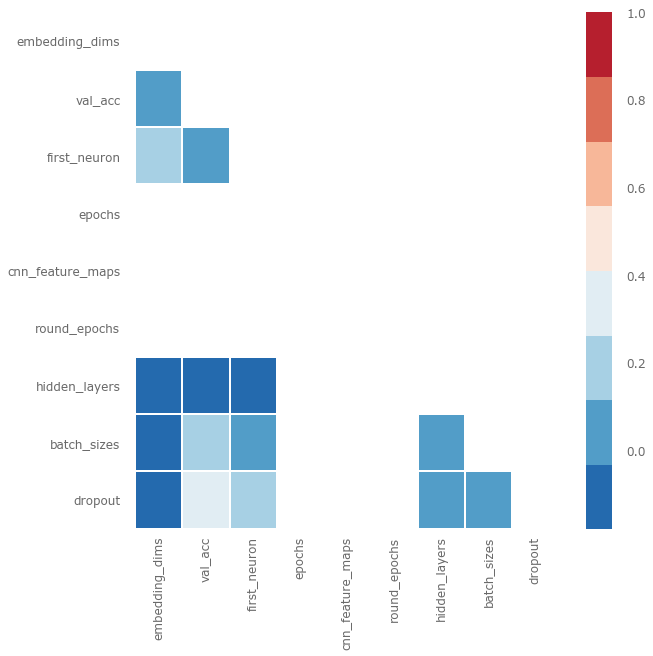

In [8]:
print(a.high('val_acc'))
a.plot_corr('val_acc', ['val_loss', 'acc', 'loss'])